In [1]:
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt 
import nilearn.plotting as niplt
%matplotlib inline 
import os 
import seaborn as sns 
from scipy.special import softmax 
import pandas as pd 

In [2]:
def get_result_dataset(dataset,rep_name,normalize_isc=True):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        if 'layer' not in rep_name and 'ling' not in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+story+"_"+rep_name+"/"
        else:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')
            results_sub=np.zeros((22,))
            noise_sub=np.zeros((22,))
            
            for roi in range(22):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
                noise_sub[roi]=noise_ceiling_parcels[np.where(roi_mapping==roi+1)].mean()
            #results_story.append(-1*np.log(results_sub/noise_sub))
            if normalize_isc:
                r=(results_sub/noise_sub)*100.0 
                r[r>100.0]=100.0
                results_story.append((results_sub/noise_sub)*100.0)
            else:
                results_story.append((results_sub))
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    results=np.concatenate(results,axis=0)
    results[np.isnan(results)]=0.0
    return results 
black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-292', 'sub-311', 'sub-267', 'sub-295', 
'sub-305', 'sub-274', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
 'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-296', 'sub-127', 'sub-279', 
 'sub-315', 'sub-314']
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']
rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG','V1']

In [3]:
layerwise=np.asarray([get_result_dataset(['black','slumlordreach'],'gptxl_layer_'+str(i)+"_activations") for i in range(48)])

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [4]:
performance=[]
layer=[]
roi=[]
for i in range(48):
    for j in range(63):
        for k in range(11):
            roi.append(rois[k])
            layer.append("Layer "+str(i+1))
            performance.append(layerwise[i,j,k])
df=pd.DataFrame(dict(performance=performance,layer=layer,roi=roi))
df

,performance,layer,roi
0,6.134513,Layer 1,PostTemp
1,-0.283233,Layer 1,AntTemp
2,-4.834949,Layer 1,AngG
3,39.132479,Layer 1,IFG
4,-15.377775,Layer 1,IFGorb
...,...,...,...
33259,25.819636,Layer 48,vmPFC
33260,24.750142,Layer 48,dmPFC
33261,13.962150,Layer 48,PMC
33262,3.644587,Layer 48,HG


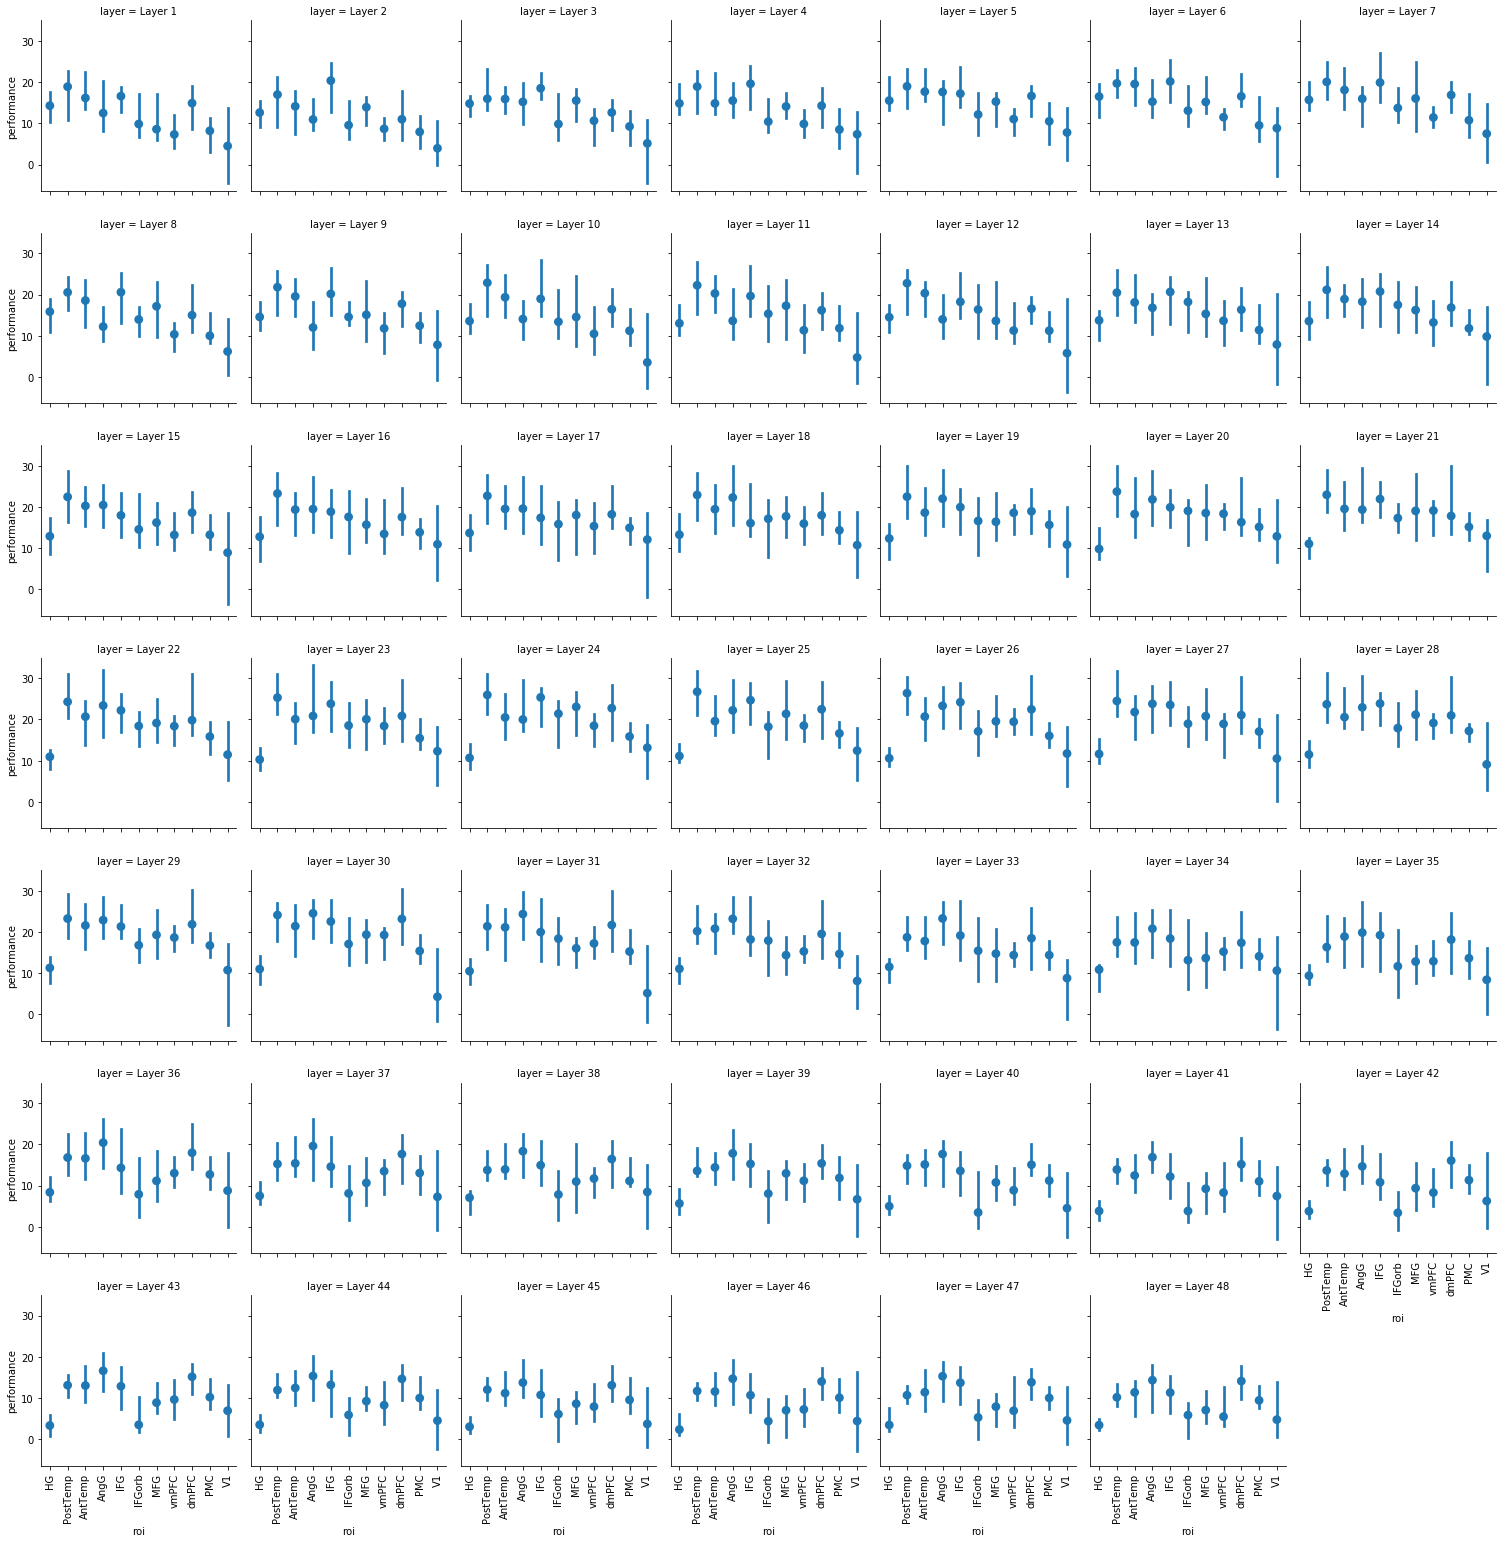

In [9]:
colors=list(sns.mpl_palette('tab10',n_colors=10).as_hex())+['#000000']
order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1']
pal=sns.color_palette(np.asarray(colors))
g=sns.FacetGrid(df,col="layer",col_wrap=7)
g.map(sns.pointplot,'roi','performance',order=order,capsize=0,estimator=np.median,join=False)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
#for i in range(len(g.axes.shape)): 
#    g.axes[i].axhline(y=0,color='black')
plt.savefig('plots/gptxl_all_layers.svg',format='svg')

In [7]:
g.axes.shape

(48,)